In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *
import tensorflow as tf

from random import random
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Dense, Embedding,GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report



In [34]:
df = pd.read_csv('cleaned-data.csv')

In [35]:
indexNames = []
for index, row in df.iterrows():
    if len(row.Genres.split("; "))>1:
        indexNames.append(index)
df = df.drop(indexNames)

In [36]:
x = np.array(df['Lyric']) #"text"
y = np.array(df['Genres'])

5


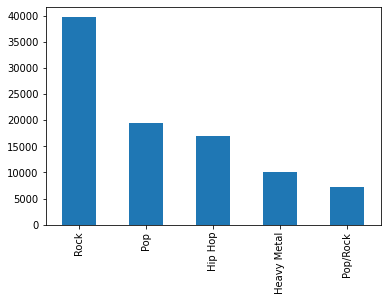

In [37]:
df['Genres'].value_counts().plot.bar()
genres = set(df["Genres"])
loss_weights = len(set(df["Genres"]))
print(loss_weights)

In [38]:
# tokenizer to transform lyrics into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=16384,
    filters='!"#$%&()*+,-.:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# updates internal vocabulary based on the lyrics
tokenizer.fit_on_texts(x)

# transform each text in x to a sequence of tokens
x = tokenizer.texts_to_sequences(x)

# pads/cuts sequences to the same length
x = pad_sequences(x, maxlen = 265)

# tokenizer to transform genres into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=1000,
    filters='!"#$%&()*+,-.:;<=>?@[]^_`{|}~\t\n',
    lower=True, split='; ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# updates internal vocabulary based on the genres
tokenizer.fit_on_texts(y)

# transform each genre in y to an integer
y = tokenizer.texts_to_sequences(y)
y = np.array([elem[0]-1 for elem in y])

In [39]:
#CNN Model
def CNN_Model(vocab_size=16384, features=32, input_length=265, learning_rate=0.001, kernel_size=2, dropout=0):
    model = Sequential()
    # Embedding layer
    model.add(Embedding(vocab_size,features,input_length=input_length))
    # Convolutional Layer
    model.add(Conv1D(input_length, kernel_size, strides=1, activation='relu'))
    
    # Pooling Layer
    model.add(GlobalMaxPooling1D())

    model.add(Dropout(dropout))
    model.add(Dense(input_length, activation='relu'))

    # Output Layer
    model.add(Dense(input_length, activation='sigmoid'))
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'], loss_weights=loss_weights)
    return model

In [40]:
x_train, y_train, x_val, y_val, x_test, y_test = split(x, y)

In [41]:
model = CNN_Model(dropout=0, features=64)

res = model.fit(x_train,np.array(y_train),validation_data=(x_val,np.array(y_val)),epochs=2)

Epoch 1/2
1757/1757 [==============================] - 133s 75ms/step - loss: 5.1583 - accuracy: 0.6176 - val_loss: 4.4392 - val_accuracy: 0.6590
Epoch 2/2
1757/1757 [==============================] - 149s 85ms/step - loss: 3.9084 - accuracy: 0.7069 - val_loss: 4.2927 - val_accuracy: 0.6761


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 265, 64)           1048576   
                                                                 
 conv1d (Conv1D)             (None, 264, 265)          34185     
                                                                 
 global_max_pooling1d (Globa  (None, 265)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 265)               0         
                                                                 
 dense (Dense)               (None, 265)               70490     
                                                                 
 dense_1 (Dense)             (None, 265)               70490     
                                                        

In [ ]:
plot_accuracy_comparison([res.history["accuracy"], res.history["val_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])


In [ ]:
plot_loss_comparison([res.history["loss"], res.history["val_loss"]],
                        "Training/Validation Loss Comparison",
                        ["Training Loss", "Validation Loss"])

586/586 [==============================] - 11s 19ms/step - loss: 4.2680 - accuracy: 0.6766
Test Loss: 4.267960548400879
Test Accuracy: 0.676647961139679


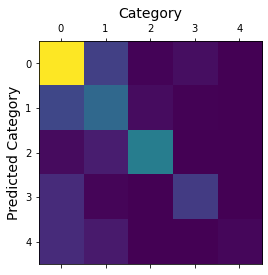

              precision    recall  f1-score   support

           0       0.81      0.67      0.74      9646
           1       0.57      0.49      0.53      4515
           2       0.79      0.90      0.84      3031
           3       0.56      0.80      0.66      1428
           4       0.07      0.89      0.14       115

    accuracy                           0.68     18735
   macro avg       0.56      0.75      0.58     18735
weighted avg       0.73      0.68      0.69     18735



In [42]:
loss, acc = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", acc)

y_pred = np.argmax(model.predict(x_test), axis=-1)
plot_confusion_matrix(y_test,y_pred)
print(classification_report(y_pred,y_test))

### Dropout Rate

In [ ]:
dropout_rates=[]
acc = []
loss = []

dp = 0
while dp <= 0.4:
    model = CNN_Model(dropout=dp)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=4)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    dropout_rates.append(dp)
    dp += 0.1

In [ ]:
plot_accuracy_comparison(acc, "Dropout Rate Comparison (Validation Accuracy)", dropout_rates)

In [ ]:
plot_loss_comparison(loss, "Learning Rate Comparison (Validation Loss)", dropout_rates)

## Features

In [ ]:
features=[]
acc = []
loss = []

f = 32
while f <= 512:
    model = CNN_Model(features=f)
    results = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=4)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])
    features.append(f)
    f *= 2

In [ ]:
plot_accuracy_comparison(acc, "Feature Amount Comparison (Validation Accuracy)", features)

In [ ]:
plot_loss_comparison(loss, "Feature Amount Comparison (Validation Loss)", features)